## Data exploration (for Calcium imaging dashboard)

This notebook is used to try out working with calcium imaging data as used in the Willuhn lab.

In [127]:
from scipy.io import loadmat
from scipy.spatial.distance import pdist
import pandas as pd
import numpy as np
import itertools
import seaborn as sns

In [128]:
data_after_CNMF_E = loadmat('data/concat_may_NoRMCorre_results.mat')

In [129]:
data_after_CNMF_E.keys()

dict_keys(['__header__', '__version__', '__globals__', 'results', '__function_workspace__'])

In [130]:
data_after_CNMF_E = data_after_CNMF_E['results']

In [131]:
print(type(data_after_CNMF_E['A'][0][0]), data_after_CNMF_E['A'][0][0].shape)
print(type(data_after_CNMF_E['C'][0][0]), data_after_CNMF_E['C'][0][0].shape)
print(type(data_after_CNMF_E['C_raw'][0][0]), data_after_CNMF_E['C_raw'][0][0].shape)

<class 'scipy.sparse.csc.csc_matrix'> (90240, 69)
<class 'numpy.ndarray'> (69, 21414)
<class 'numpy.ndarray'> (69, 21414)


In [132]:
# Extract options: (don't ask me why MATLAB stores it like this..)
options = {}

names_dict = data_after_CNMF_E['options'][0][0].dtype
names = [name for name in names_dict.fields.keys()]

for i in range(26):
    option = data_after_CNMF_E['options'][0][0][0][0][i][0]
    if(isinstance(option, str)):
        options[names[i]] = option
    elif(isinstance(option, np.ndarray)):
        options[names[i]] = option[0]

In [133]:
A_df = pd.DataFrame(data_after_CNMF_E['A'][0][0].todense())
print(type(A_df), A_df.shape)
A_df.describe()

<class 'pandas.core.frame.DataFrame'> (90240, 69)


,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
count,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,...,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000,90240.000000
mean,0.000451,0.000380,0.000324,0.000334,0.000257,0.001325,0.000919,0.001647,0.000869,0.000897,...,0.000641,0.000692,0.000311,0.000465,0.000397,0.000213,0.000520,0.000398,0.000369,0.000392
std,0.007093,0.006608,0.005496,0.005093,0.005301,0.017720,0.011573,0.020909,0.009993,0.011018,...,0.010055,0.008093,0.007343,0.007164,0.004724,0.003896,0.005954,0.007356,0.004981,0.014969
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.209099,0.238131,0.213798,0.187568,0.245116,0.459054,0.289028,0.508889,0.220482,0.237655,...,0.276841,0.153818,0.269143,0.175743,0.100418,0.135737,0.117834,0.217875,0.111419,1.017321


In [134]:
C_df = pd.DataFrame(data_after_CNMF_E['C'][0][0])
C_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,21404,21405,21406,21407,21408,21409,21410,21411,21412,21413
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,6.900000e+01,6.900000e+01,6.900000e+01,6.900000e+01,6.900000e+01,6.900000e+01,6.900000e+01,6.900000e+01,6.900000e+01,6.900000e+01
mean,4.414565,4.110339,4.179116,4.010279,3.923681,3.990513,3.855040,3.759736,3.764686,3.663641,...,2.921609e+00,3.008819e+00,3.157201e+00,3.108931e+00,3.061504e+00,3.014903e+00,3.061161e+00,3.014135e+00,2.967932e+00,3.002684e+00
std,5.689808,5.687278,6.035357,5.941588,5.832882,5.689874,5.603636,5.500503,5.468696,5.343508,...,5.960226e+00,5.956961e+00,6.018384e+00,5.947371e+00,5.877513e+00,5.808786e+00,5.817187e+00,5.747877e+00,5.679723e+00,5.610063e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.471872,0.040771,0.022236,0.001720,0.000133,0.001501,0.047279,0.030456,0.002356,0.000182,...,2.348090e-09,2.235656e-09,2.128606e-09,2.026681e-09,1.929637e-09,1.837240e-09,1.749267e-09,1.665507e-09,1.585757e-09,1.509826e-09
50%,2.525336,2.260843,2.260487,2.118997,2.051446,2.207267,2.024935,1.951760,1.881229,1.813248,...,3.155321e-01,3.094642e-01,3.161014e-01,3.105960e-01,3.051866e-01,2.998713e-01,2.946486e-01,2.895169e-01,2.844746e-01,3.053911e-01
75%,6.506775,6.364675,6.225679,6.036834,5.849093,5.667190,5.699392,5.320180,5.453176,5.334085,...,3.473466e+00,3.617524e+00,4.091209e+00,4.019077e+00,3.948216e+00,3.872024e+00,3.794589e+00,3.718703e+00,3.644335e+00,3.612220e+00
max,31.532785,30.926386,36.557435,35.854409,35.164902,34.488655,33.825412,33.174924,32.536946,31.911236,...,3.737192e+01,3.707630e+01,3.678301e+01,3.649205e+01,3.620338e+01,3.591700e+01,3.563289e+01,3.535102e+01,3.507138e+01,3.479396e+01


In [135]:
C_raw_df = pd.DataFrame(data_after_CNMF_E['C_raw'][0][0])
C_raw_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,21404,21405,21406,21407,21408,21409,21410,21411,21412,21413
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,3.216818,3.660473,3.557659,3.524597,3.540554,3.405464,3.640791,3.390490,3.749805,3.707609,...,3.092936,3.079175,2.938855,3.008251,3.478212,2.927562,3.235690,3.191409,3.328066,3.169678
std,5.726110,5.861692,5.943217,5.945353,5.677185,5.719680,5.511188,5.675727,5.600202,5.458411,...,5.919265,5.822839,5.863774,5.966519,5.896694,5.813708,5.809700,5.800738,5.685468,5.567258
min,-2.564333,-2.846126,-2.361768,-2.992085,-2.274645,-1.856157,-1.905621,-2.637784,-3.750772,-3.591860,...,-3.566258,-3.117687,-6.398604,-3.671907,-4.446409,-3.302586,-2.213819,-2.331139,-2.594813,-2.413952
25%,-0.452475,-0.035668,0.403891,0.116477,0.379423,0.455970,0.457228,0.523976,0.690777,0.725751,...,0.070322,0.013176,0.172240,0.290139,0.819010,-0.223624,0.089726,0.030405,0.253289,0.109662
50%,1.608913,1.813220,2.209639,2.072095,2.165464,1.410254,2.044480,1.827912,2.302042,2.292587,...,1.523029,1.412354,1.531311,1.436120,1.934445,1.236464,1.613274,1.296646,1.925880,1.296366
75%,4.450269,5.039383,4.537136,4.546127,4.698873,4.287877,4.661163,3.998236,5.561425,4.994734,...,3.692923,3.627990,3.058609,3.014674,3.355409,3.015341,3.313220,3.470115,3.598977,3.731563
max,29.072650,33.434759,35.350266,35.296949,34.852910,33.871325,32.415119,34.019204,32.358011,30.953098,...,37.378419,36.692486,36.628452,35.937754,36.322826,35.534785,35.737767,36.622478,34.693460,34.003311


### What I want to extract from the data for now:
- Centroid of each neuron (for calculating the distance between neurons)
- Pairwise distance between each neuron (for grouping very close/overlapping neurons, to check if they might be duplicates)
- Fluorescence trace for each neuron(for plotting a timeseries of & for calculating cross-correlation)
- Cross correlation of Fluorescence trace (for checking if there might be duplicates) (NB: VECTORISED/MATRIX)
- .tif video with cutout of each neuron (for showing a video of)

#### Centroid of each neuron (for calculating the distance between neurons)

In [136]:
number_of_pixels = A_df.shape[0]
number_of_neurons = A_df.shape[1]

df = A_df

# Keep all rows (pixels) that have non-zero values, and store their non-zero columns (neurons) and their values in a "stack"
non_zero_df = df[df!=0]
pixels_containing_neurons_stack = non_zero_df.stack()

# Select rows (pixels) that contain the column (neuron) of interest
# TODO: Factorise this?
pixels_all_neurons = []          
for i in range(number_of_neurons):
    pixels = [pixel for (pixel, neuron) in pixels_containing_neurons_stack.keys() if neuron == i]
    pixels_all_neurons.append(pixels)

# Put data in a dataframe  
# NB: this pads the shorter lists with NaNs
# TODO: Factorise this? (use numpy in 3d instead of pandas Dataframe)
df = pd.DataFrame(pixels_all_neurons)

# use dimensions d1 & d2 to figure out where the pixels are 
# TODO find out how to unpack this vector into (row,col) (even though there's padding)
d1 = options["d1"]
d2 = options["d2"]
col_df = df.apply(lambda x: x%d1)
row_df = df.apply(lambda x: x//d1)

# Calculate the mean values for the dataframe
col_df_mean = col_df.mean(axis=1)
row_df_mean = row_df.mean(axis=1)

mean_locations = []
for i in range(number_of_neurons):
    mean_locations.append((col_df_mean[i], row_df_mean[i]))
mean_locations_df = pd.DataFrame(mean_locations)

 #### Pairwise distance between each neuron (for grouping very close/overlapping neurons, to check if they might be duplicates)

In [137]:
# Calculate pairwise euclidian distance
distance_df = pd.DataFrame(itertools.combinations(mean_locations_df.index,2), columns = ['neuron_1','neuron_2'])
distance_df['distance'] = pdist(mean_locations_df.values, 'euclid')

# Select neurons that are very close together
# TODO: write test cases to check that algorithms work as intended
small_distance = 10
neurons_close_to_another_df = distance_df[distance_df['distance'] < small_distance]

#### Fluorescence trace for each neuron(for plotting a timeseries of & for calculating cross-correlation)

In [138]:
# fluorescence traces == C_raw (right??)
fluorescence_traces = C_raw_df

#### Cross correlation of Fluorescence trace (for checking if there might be duplicates)

In [139]:
correlation_matrix = np.corrcoef(fluorescence_traces)
correlation_matrix = np.absolute(correlation_matrix)

correlation_df = pd.DataFrame(correlation_matrix)
# Discard the lower left triangle as all correlation values will end up as doubles (includes the diagonal of 1.0's)
correlation_df = correlation_df.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
correlation_series = correlation_df.stack()
correlations_sorted = correlation_series.sort_values(kind="quicksort")

highly_correlating_neurons = correlations_sorted[correlations_sorted>0.6]

<AxesSubplot:>

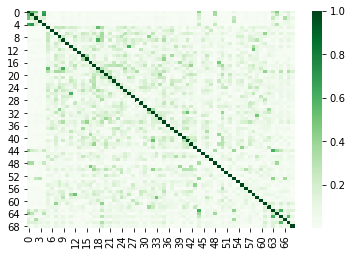

In [140]:
#plots for sanity check
sns.heatmap(correlation_matrix, cmap="Greens")

11  26    0.603084
44  63    0.603142
63  65    0.603938
9   18    0.606365
0   4     0.642726
1   4     0.696667
dtype: float64


<AxesSubplot:>

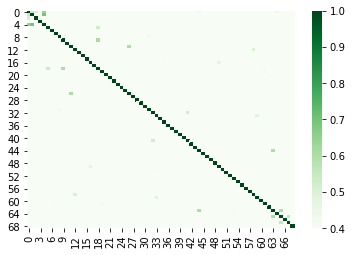

In [141]:
print(highly_correlating_neurons)
sns.heatmap(correlation_matrix, cmap="Greens", vmin=0.4)

In [142]:
double_selection_df = distance_df
double_selection_df['correlation'] = correlation_series.values
double_selection_df = double_selection_df[double_selection_df['distance'] < 10]
double_selection_df = double_selection_df[double_selection_df['correlation'] > 0.6]
double_selection_df

,neuron_1,neuron_2,distance,correlation
70,1,4,8.802322,0.696667
2064,44,63,7.431400,0.603142


#### .tif video with cutout of each neuron (for showing a video of)